# Временные ряды

*Подготовил Ян Пиле*

Временной ряд – набор данных, зависящих от времени (Каждой точке присвоена определенная временная метка). В идеале эти точки данных должны быть расположены в хронологическом порядке с одинаковыми временные интервалы (например, раз в минуту или раз в день). Задача прогнозирования временных рядов – собрать закономерности из прошлого, чтобы сделать прогнозы на будущее. Так, например, могут прогнозировать цены на акции (и почти всегда очень плохо). Но так, например, можно прогнозировать интересующие вас метрики вперед, чтоб планировать "что делать дальше". В отличие данных для стандартных задач регрессии, данные временного ряда ОЧЕВИДНО зависимы.

# Задача

#### прогнозирования глубины залегания водоносного горизонта, расположенного в Петриньяно, Италия. 

**Вопрос:**
Какова будущая глубина грунтовых вод колодца, принадлежащего водоносному горизонту в Петриньяно, в следующем квартале?

Поле колодцев на аллювиальной равнине между Оспедаликкьо ди Бастия Умбра и Петриньяно питается тремя подземными водоносными горизонтами, разделенными перегородками с низкой проницаемостью. Кроме того, грунтовые водами питаются от реки Кьяскио. 

Итого - на уровень грунтовых вод влияют следующие параметры: 

* количество осадков
* глубина залегания грунтовых вод
* температура и объемы дренажа
* уровень реки Кьяскио.

Действительно, и осадки, и температура влияют на такие характеристики, как уровень, скорость оттока, глубина грунтовых вод.

P.S. Данные временных рядов обычно поступают в табличном формате (например, файлы CSV)

In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns # Visualization


from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

df = pd.read_csv("Aquifer_Petrignano.csv")
print(df.shape)
df.head()

(5223, 8)


,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [21]:
# Выкинем лишнее
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
print(df.shape)

# Выкинем лишние поля
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# И переименуем
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

(4199, 8)


,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


Приведем дату в божеский вид

In [22]:
from datetime import datetime, date 

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


**Признаки:**

* Rainfall - сколько дождя выпало в миллиметрах
* Temperature - в градусах Цельсия (°C)
* Volume - Сколько воды забрали в кубометрах 
* Hydrometry уровень грунтовых вод в метрах(m)

**Целевая переменная:**

* Depth to Groundwater глубина до поверхности воды от поверзности земли в метрах

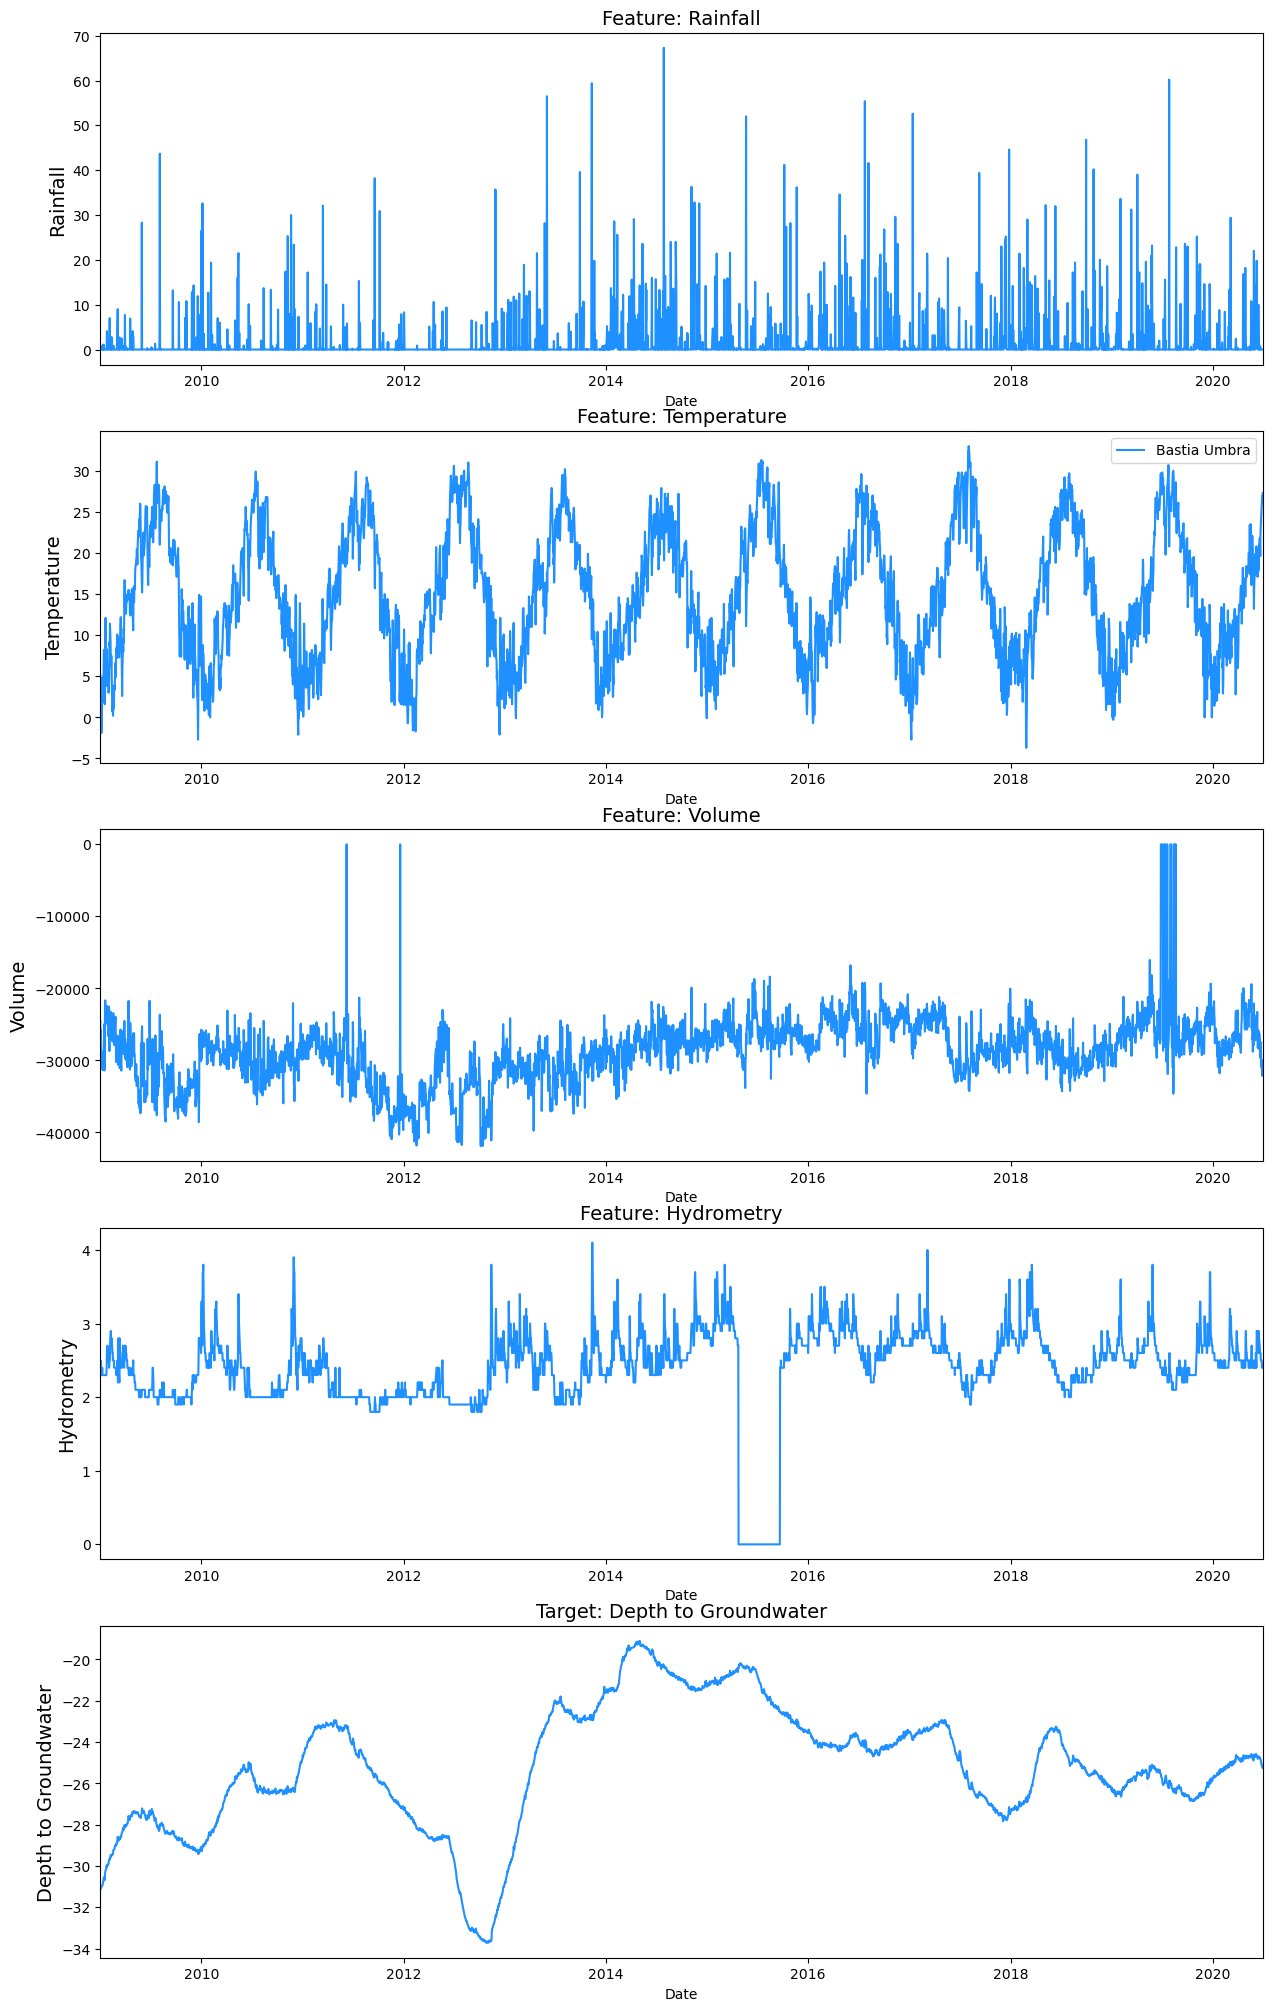

In [23]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.Date, y=df.Rainfall.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Rainfall', fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall', fontsize=14)


sns.lineplot(x=df.Date, y=df.Temperature.fillna(np.inf), ax=ax[1], color='dodgerblue',label='Bastia Umbra')
ax[1].set_title('Feature: Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)


sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Volume', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)


sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: Hydrometry', fontsize=14)
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)


sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Target: Depth to Groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(5):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

# Предварительная обработка данных

## Хронологический порядок и равноотстоящие временные метки
Данные должны быть расположены в хронологическом порядке, а временные метки должны быть на равном расстоянии. Хронологический порядок == *sorted*. Если расстояния не равны, дырки придется чем-то заткнуть.

В наших данных – временной интервал составляет один день, и все уже расположены в хронологическом порядке. Поэтому делать ничего не будем)

In [24]:
df = df.sort_values(by='Date')

df['Time_Interval'] = df.Date - df.Date.shift(1)

df[['Date', 'Time_Interval']].Time_Interval.unique()

array([         'NaT', 86400000000000], dtype='timedelta64[ns]')

##  Обработка пропущенных значений

у **Depth_to_Groundwater** есть пропуски .

Более того, построение временного ряда показывает, что существуют некоторые неправдоподобные нулевые значения для **Drainage_Volume** и **River_Hydrometry**. С ними надо разобраться, например, заменив значениями nan, а затем заполнить.

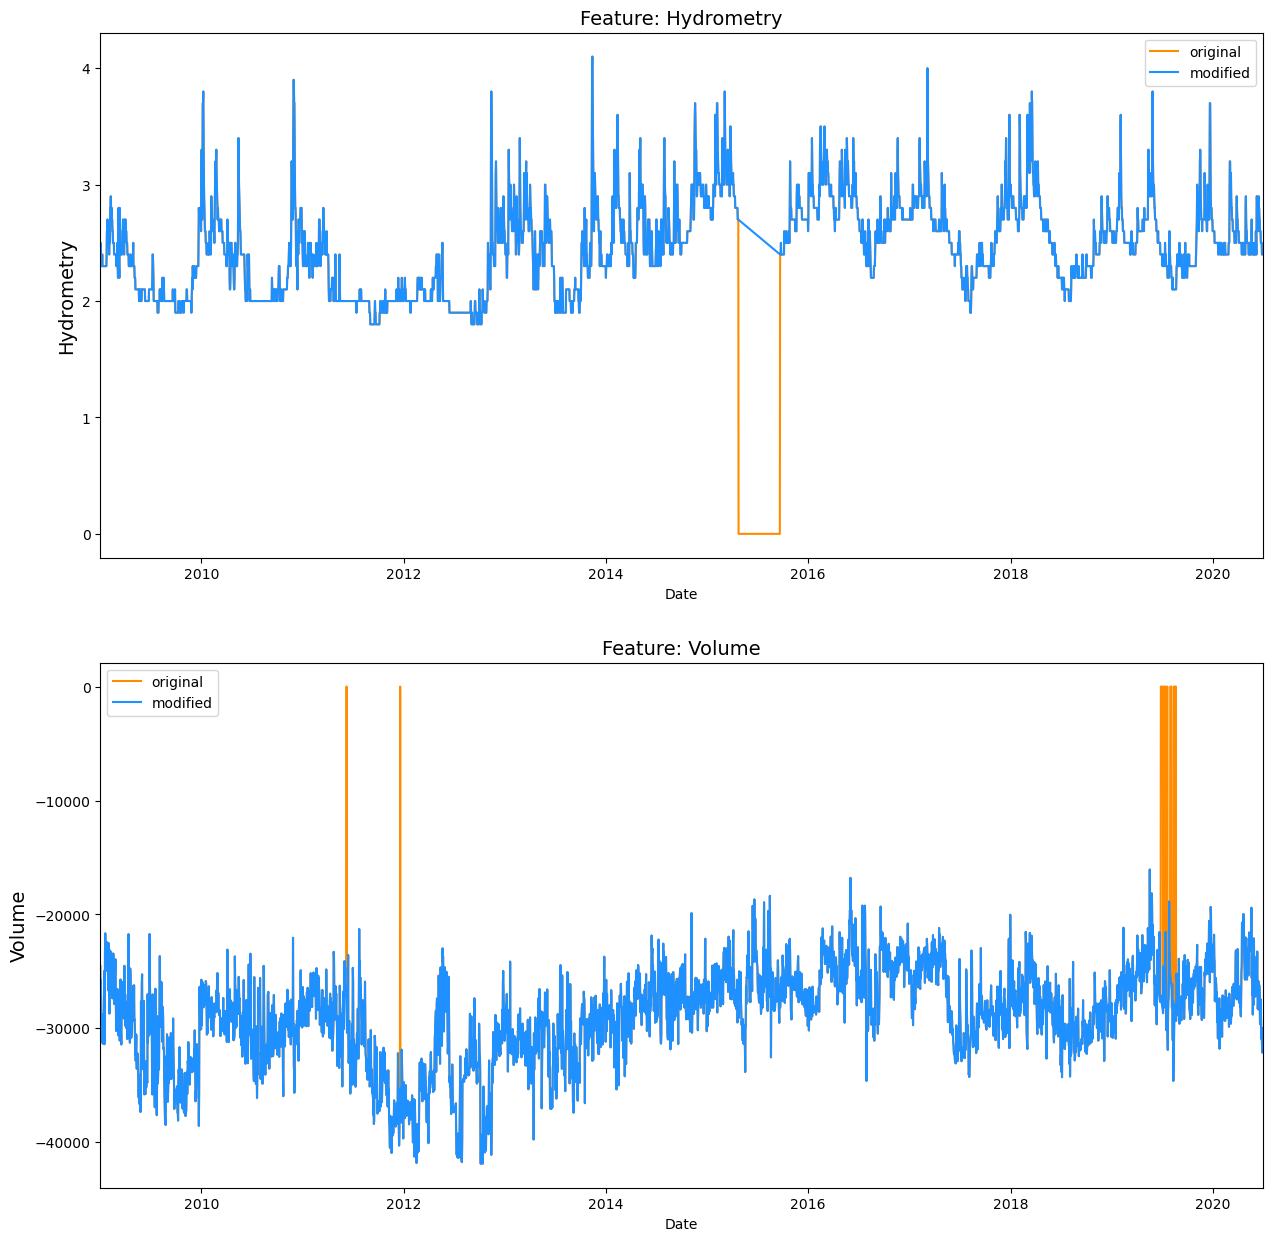

In [25]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
old = df.River_Hydrometry.copy()
df['River_Hydrometry'] = np.where((df.River_Hydrometry == 0),np.nan, df.River_Hydrometry)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[0], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)

old = df.Drainage_Volume.copy()
df['Drainage_Volume'] = np.where((df.Drainage_Volume == 0),np.nan, df.Drainage_Volume)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[1], color='darkorange', label = 'original')

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'modified')
ax[1].set_title('Feature: Volume', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)


for i in range(2):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

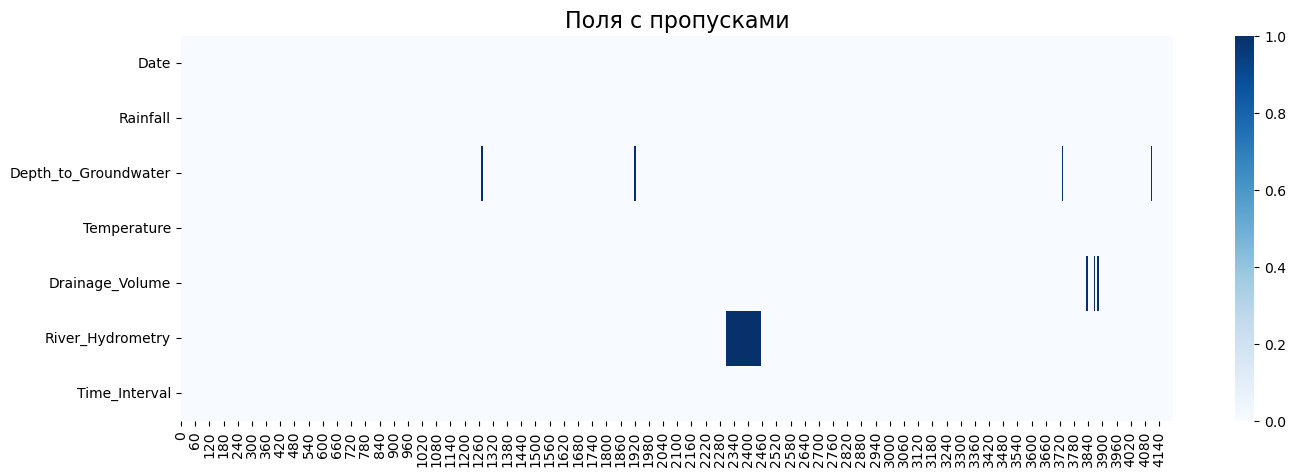

In [26]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Поля с пропусками', fontsize=16)

plt.show()

## Практические способы затыкания дырок

* Способ 1: Заполняем NaN выбросами или нулями

* Способ 2: Заполняем NaN средним

* Способ 3: Заполняем NaN последним доступным значением через **.ffill()**

* Способ 4: Заполняем NaN с помощью линейной интерполяции **..interpolate()**.

* Способ 5: Заполняем NaN cкользязим средним.

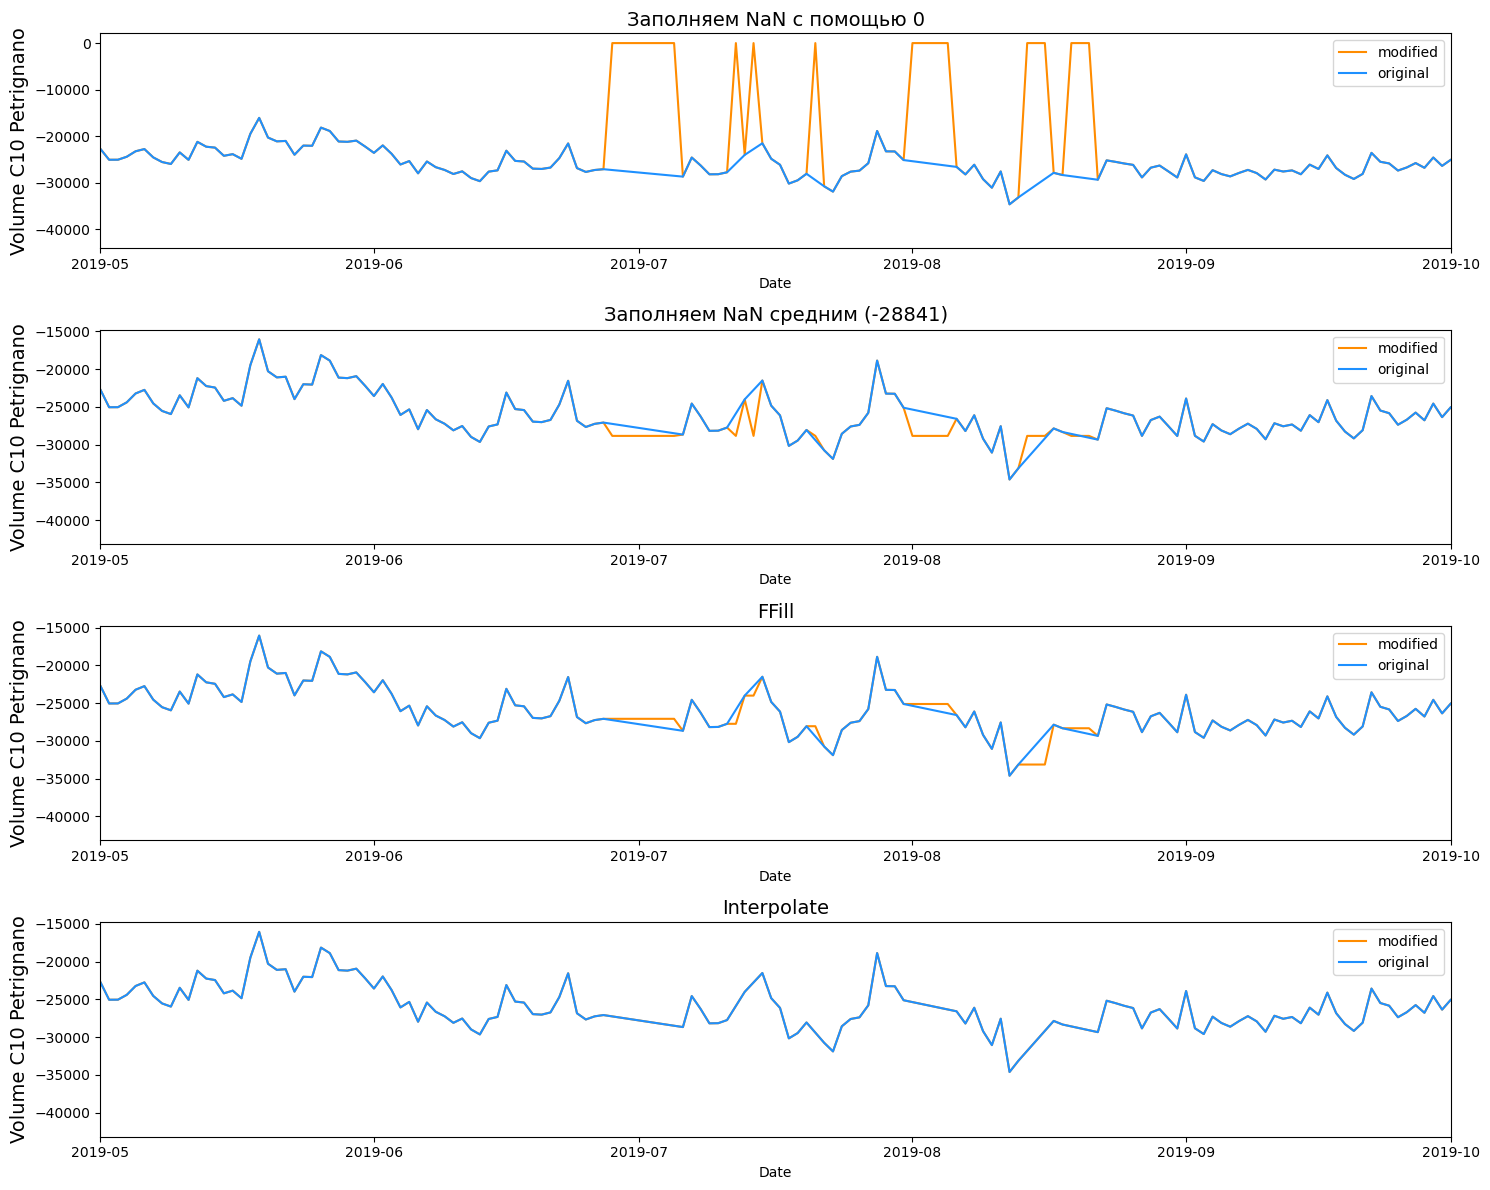

In [27]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')

ax[0].set_title('Заполняем NaN с помощью 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_val = df.Drainage_Volume.mean()
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Заполняем NaN средним ({mean_val:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()

In [28]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

## Resampling

* **Upsampling** делаем чаще (дни -> часы)
* **Downsampling** делаем реже (дни -> недели)

У нас будет Downsampling (делается через .resample())

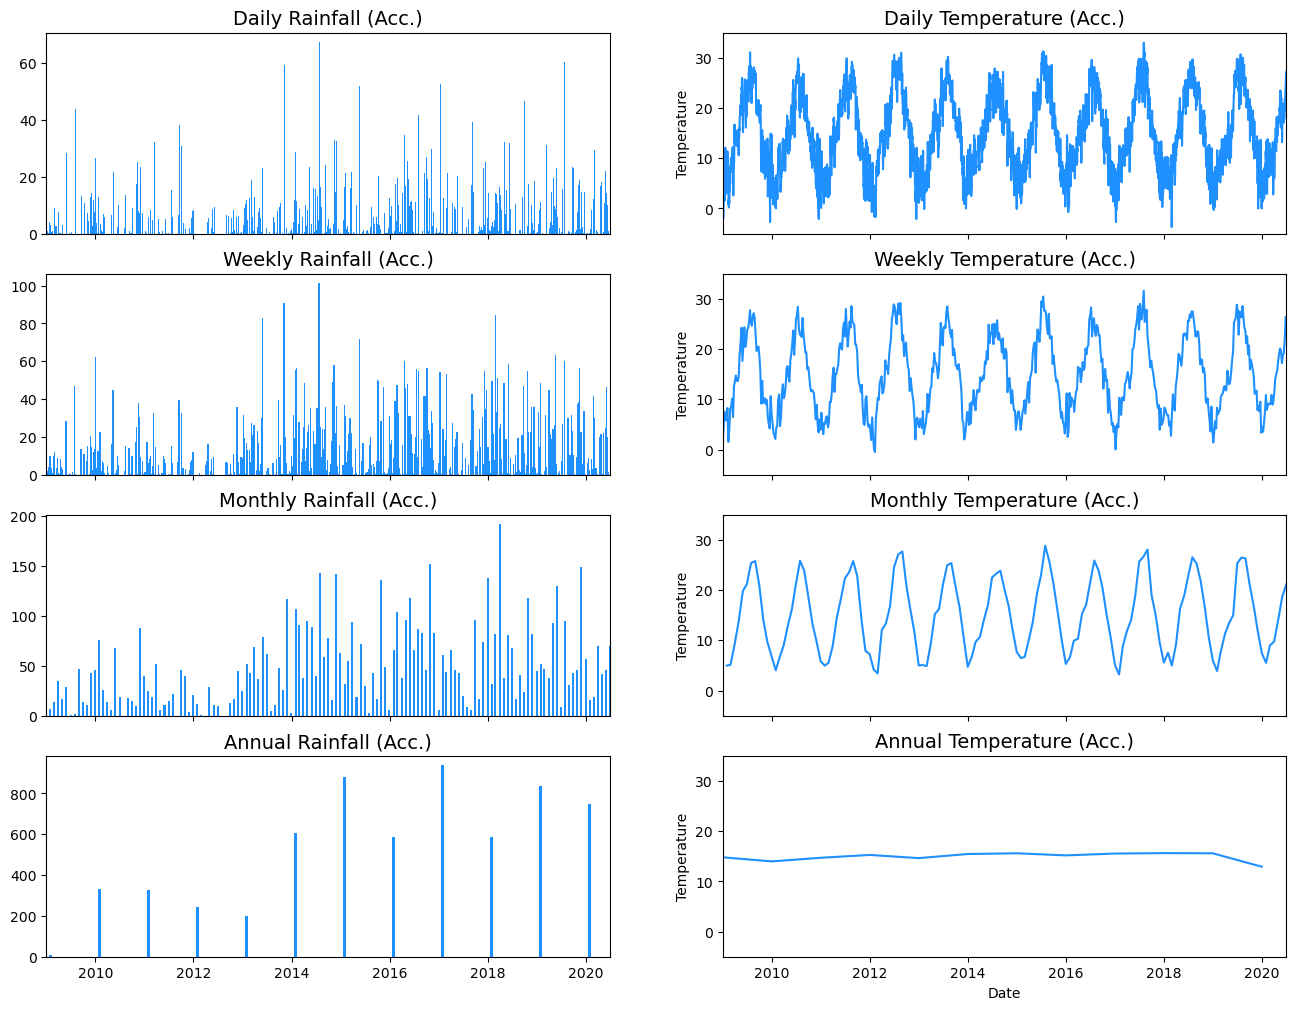

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,12))

ax[0, 0].bar(df.Date, df.Rainfall, width=5, color='dodgerblue')
ax[0, 0].set_title('Daily Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)
ax[1, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=10, color='dodgerblue')
ax[1, 0].set_title('Weekly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('M', on='Date').sum().reset_index(drop=False)
ax[2, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=15, color='dodgerblue')
ax[2, 0].set_title('Monthly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('12M', on='Date').sum().reset_index(drop=False)
ax[3, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=20, color='dodgerblue')
ax[3, 0].set_title('Annual Rainfall (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x = df.Date, y = df.Temperature, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(x = resampled_df.Date, y = resampled_df.Temperature, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('M', on='Date').mean().reset_index(drop=False)
sns.lineplot(x = resampled_df.Date, y = resampled_df.Temperature, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('365D', on='Date').mean().reset_index(drop=False)
sns.lineplot(x = resampled_df.Date, y = resampled_df.Temperature, color='dodgerblue', ax=ax[3, 1])
ax[3, 1].set_title('Annual Temperature (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_ylim([-5, 35])
plt.show()

In [31]:
# Загрубим данные до недели 

df_downsampled = df[['Date',
                     'Depth_to_Groundwater', 
                     'Temperature',
                     'Drainage_Volume', 
                     'River_Hydrometry'
                    ]].resample('7D', on='Date').mean().reset_index(drop=False)

df_downsampled['Rainfall'] = df[['Date',
                                 'Rainfall'
                                ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]

df = df_downsampled

## Стационарность
Некоторые модели временных рядов, такие как **ARIMA**, предполагают, что базовые данные стационарны. Стационарность означает, что временной ряд имеет:

* постоянное среднее значение и среднее значение не зависят от времени
* постоянную дисперсию и дисперсия не зависят от времени
* постоянную ковариацию и ковариация не зависят от времени

Логика проста - если ряд стационарен и ведет себя так сегодня, завтра будет вести себя так же :)

Временные ряды с трендом и/или сезонностью не являются стационарными (очевидно)

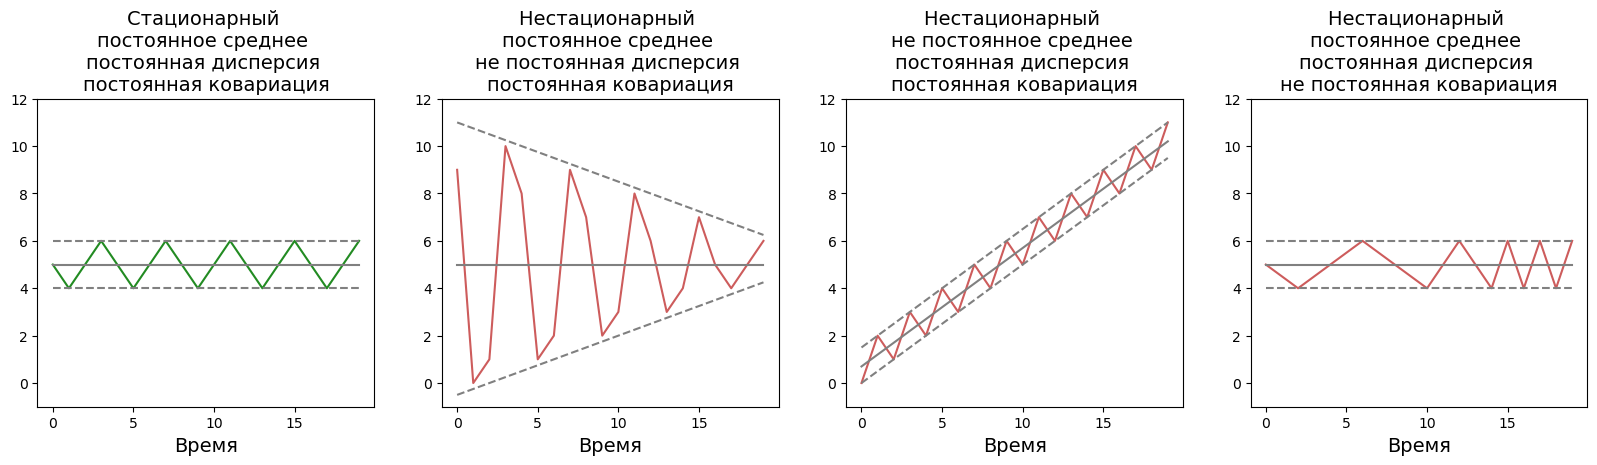

In [33]:
t = np.linspace(0, 19, 20)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
stationary = [5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6,]
sns.lineplot(x=t, y=stationary, ax=ax[0], color='forestgreen')
sns.lineplot(x=t, y=5, ax=ax[0], color='grey')
sns.lineplot(x=t, y=6, ax=ax[0], color='grey')
sns.lineplot(x=t, y=4, ax=ax[0], color='grey')
ax[0].lines[2].set_linestyle("--")
ax[0].lines[3].set_linestyle("--")
ax[0].set_title(f'Стационарный \nпостоянное среднее \nпостоянная дисперсия \nпостоянная ковариация', fontsize=14)

nonstationary1 = [ 9, 0, 1, 10, 8, 1, 2, 9, 7, 2, 3, 8, 6, 3, 4, 7, 5, 4, 5, 6]
sns.lineplot(x=t, y=nonstationary1, ax=ax[1], color='indianred' )
sns.lineplot(x=t, y=5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*0.25-0.5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*(-0.25)+11, ax=ax[1], color='grey')
ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")
ax[1].set_title(f'Нестационарный \nпостоянное среднее \nне постоянная дисперсия \nпостоянная ковариация', fontsize=14)

nonstationary2 = [0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11,]
sns.lineplot(x=t, y=nonstationary2, ax=ax[2], color='indianred' )
sns.lineplot(x=t, y=t*0.5+0.7, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5+1.5, ax=ax[2], color='grey')
ax[2].lines[2].set_linestyle("--")
ax[2].lines[3].set_linestyle("--")
ax[2].set_title(f'Нестационарный \nне постоянное среднее \nпостоянная дисперсия \nпостоянная ковариация', fontsize=14)

nonstationary3 = [5, 4.5, 4, 4.5, 5, 5.5, 6, 5.5, 5, 4.5, 4, 5, 6, 5, 4, 6, 4, 6, 4, 6,]
sns.lineplot(x=t, y=nonstationary3, ax=ax[3], color='indianred')
sns.lineplot(x=t, y=5, ax=ax[3], color='grey')
sns.lineplot(x=t, y=6, ax=ax[3], color='grey')
sns.lineplot(x=t, y=4, ax=ax[3], color='grey')
ax[3].lines[2].set_linestyle("--")
ax[3].lines[3].set_linestyle("--")
ax[3].set_title(f'Нестационарный \nпостоянное среднее \nпостоянная дисперсия \nне постоянная ковариация', fontsize=14)

for i in range(4):
    ax[i].set_ylim([-1, 12])
    ax[i].set_xlabel('Время', fontsize=14)

## Проверка стационарности:

* **визуально**: графики строим и вперед
* **базовая статистика**: разделите временные ряды на интервалы и сравните среднее значения и дисперсию каждого раздела
* **статистический тест**: расширенный тест Дики Фуллера



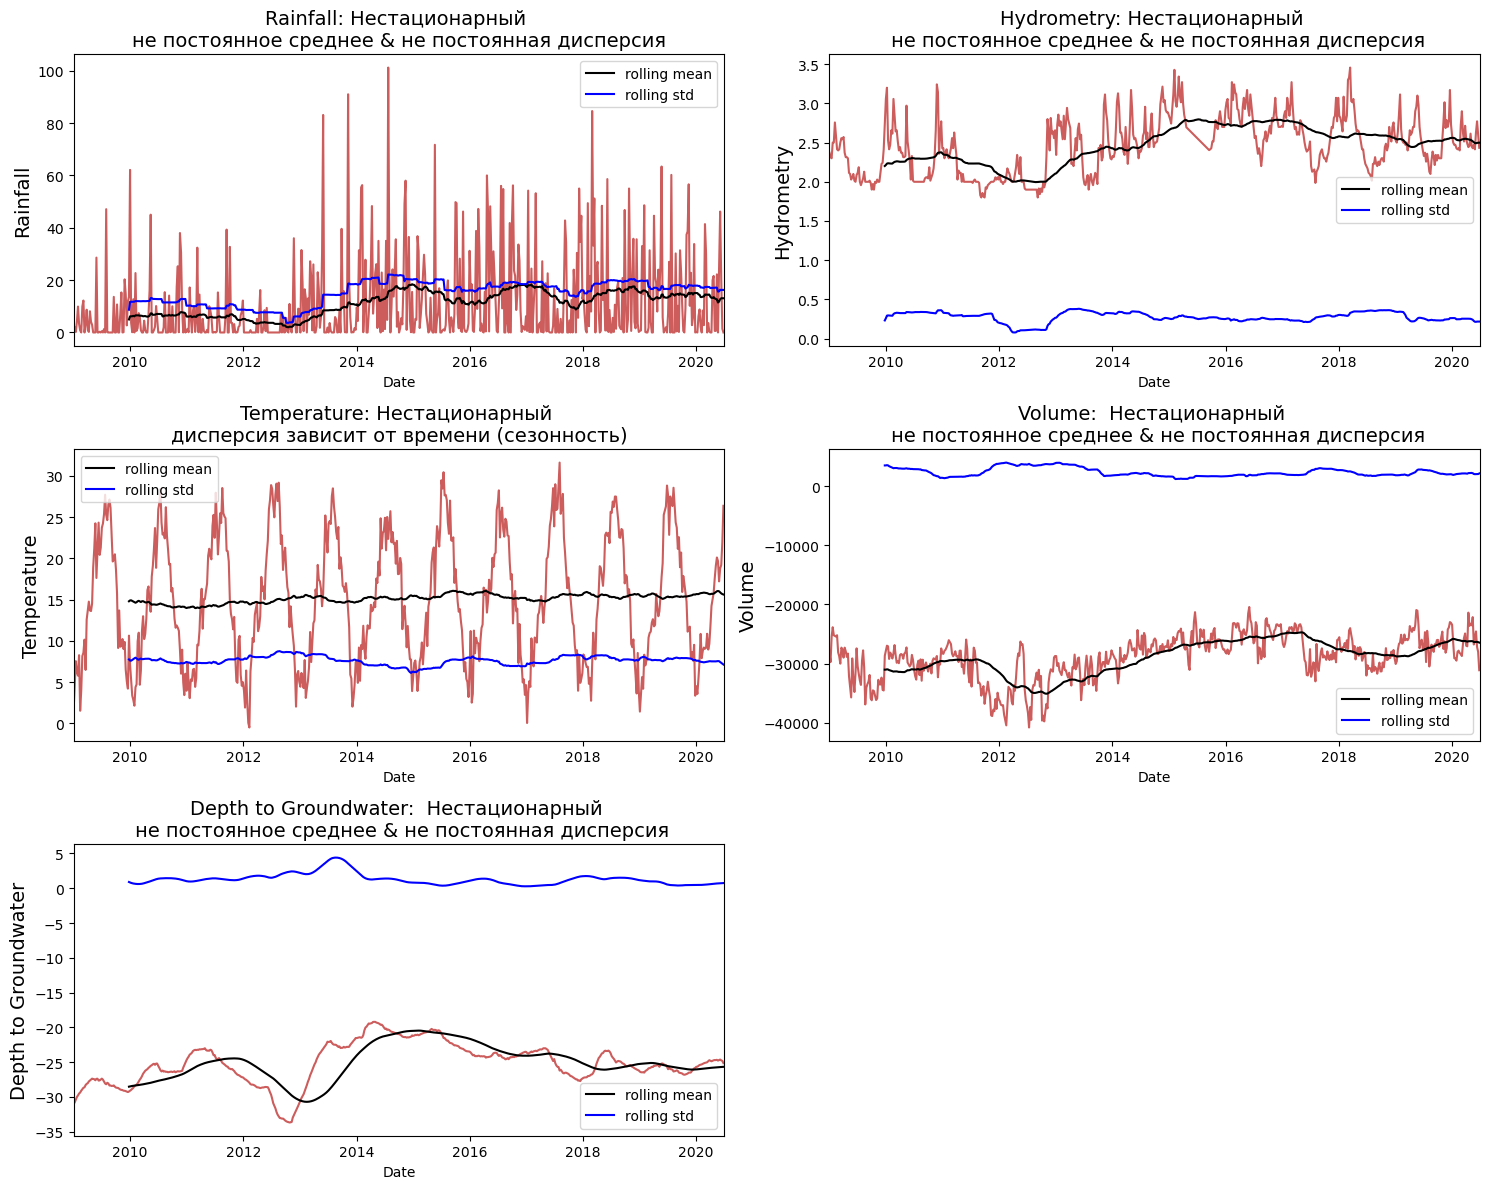

In [34]:
rolling_window = 52
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Rainfall, ax=ax[0, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
ax[0, 0].set_title('Rainfall: Нестационарный \nне постоянное среднее & не постоянная дисперсия', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature, ax=ax[1, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).mean(), ax=ax[1, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).std(), ax=ax[1, 0], color='blue', label='rolling std')
ax[1, 0].set_title('Temperature: Нестационарный \nдисперсия зависит от времени (сезонность)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry, ax=ax[0, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).mean(), ax=ax[0, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).std(), ax=ax[0, 1], color='blue', label='rolling std')
ax[0, 1].set_title('Hydrometry: Нестационарный \n не постоянное среднее & не постоянная дисперсия', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume, ax=ax[1, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).mean(), ax=ax[1, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).std(), ax=ax[1, 1], color='blue', label='rolling std')
ax[1, 1].set_title('Volume:  Нестационарный \n не постоянное среднее & не постоянная дисперсия', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater, ax=ax[2, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).mean(), ax=ax[2, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).std(), ax=ax[2, 0], color='blue', label='rolling std')
ax[2, 0].set_title('Depth to Groundwater:  Нестационарный \n не постоянное среднее & не постоянная дисперсия', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(3):
    ax[i,0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i,1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Все показатели, кроме температуры, имеют непостоянное среднее значение и непостоянную дисперсию. Поэтому ни один из них не кажется стационарным. Однако температура демонстрирует сильную сезонность (жарко летом, холодно зимой) и поэтому не является стационарной.

Далее побьем на куски и проверим статистики

,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry,Rainfall
0,-31.048571,1.657143,-28164.918857,2.371429,0.0
1,-30.784286,4.571429,-29755.789714,2.314286,2.0
2,-30.420000,7.528571,-25463.190857,2.300000,0.2
3,-30.018571,6.214286,-23854.422857,2.500000,4.1
4,-29.790000,5.771429,-25210.532571,2.500000,9.9
...,...,...,...,...,...
595,-24.697143,17.214286,-25591.062857,2.414286,24.6
596,-24.638571,18.785714,-24567.099429,2.628571,46.2
597,-24.751429,19.200000,-27178.416000,2.771429,20.0
598,-24.822857,21.942857,-28030.134857,2.600000,1.4


In [35]:
num_partitions = 2
partition_length = int(len(df) / num_partitions)

partition1_mean = df[df.columns[1:]].head(partition_length).mean()
partition1_var = df[df.columns[1:]].head(partition_length).var()
partition2_mean = df[df.columns[1:]].tail(partition_length).mean()
partition2_var = df[df.columns[1:]].tail(partition_length).var()

In [36]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']

def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])

    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1


stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")

,Partition 1 Mean,Partition 2 Mean,Partition 1 Variance,Partition 2 Variance
Depth_to_Groundwater,-26,-24,13,4
Temperature,15,15,58,56
Drainage_Volume,"-30,989","-26,684","12,053,921","5,955,484"
River_Hydrometry,2,3,0,0
Rainfall,8,14,197,306


И еще гистограммы посмотрим

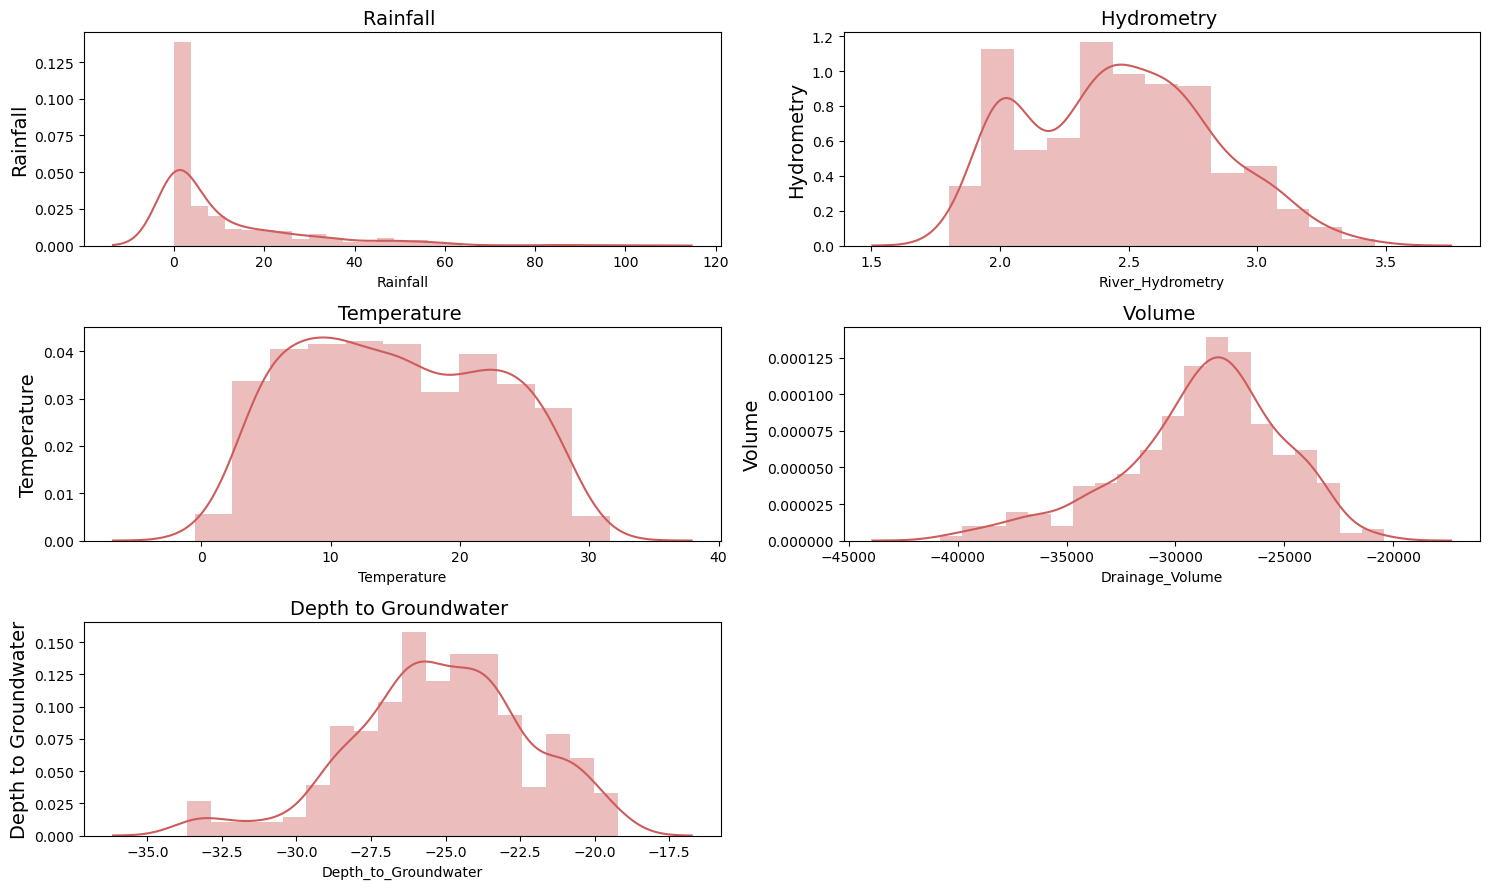

In [37]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

sns.distplot(df.Rainfall.fillna(np.inf), ax=ax[0, 0], color='indianred')
ax[0, 0].set_title('Rainfall ', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.distplot(df.Temperature.fillna(np.inf), ax=ax[1, 0], color='indianred')
ax[1, 0].set_title('Temperature ', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.distplot(df.River_Hydrometry.fillna(np.inf), ax=ax[0, 1], color='indianred')
ax[0, 1].set_title('Hydrometry ', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.distplot(df.Drainage_Volume.fillna(np.inf), ax=ax[1, 1], color='indianred')
ax[1, 1].set_title('Volume ', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.distplot(df.Depth_to_Groundwater.fillna(np.inf), ax=ax[2, 0], color='indianred')
ax[2, 0].set_title('Depth to Groundwater ', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

### Расширенный тест Дикки-Фуллера (ADF)

Называется тестом единичного корня. Единичные корни часто являются причиной нестационарности.

**Нулевая гипотеза (H0)**: временной ряд имеет единичный корень. (Временной ряд не стационарен).

**Альтернативная гипотеза (H1)**: Временной ряд не имеет единичного корня (временной ряд стационарен).

Если H0 отвергается, временной ряд стационарен.


С одной стороны, нулевая гипотеза может быть отклонена, если значение **pvalue** ниже установленного уровня значимости. 

**pvalue > уровень значимости (по умолчанию: 0,05)**: не удалось отвергнуть нулевую гипотезу (H0), есть единичный корень, нестационарно.

**pvalue <= уровень значимости (по умолчанию: 0,05)**: отклоняем нулевую гипотезу (H0), данные не имеют единичного корня и являются стационарными.

С другой стороны, нулевая гипотеза может быть отклонена, если тестовая статистика меньше критического значения.

**Статистика ADF > критического значения**: не удалось отвергнуть нулевую гипотезу (H0), есть единичный корень, нестационарно.

**Статистика ADF < критическое значение**: отклоняем нулевую гипотезу (H0), данные не имеют единичного корня и являются стационарными.

In [38]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Depth_to_Groundwater.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

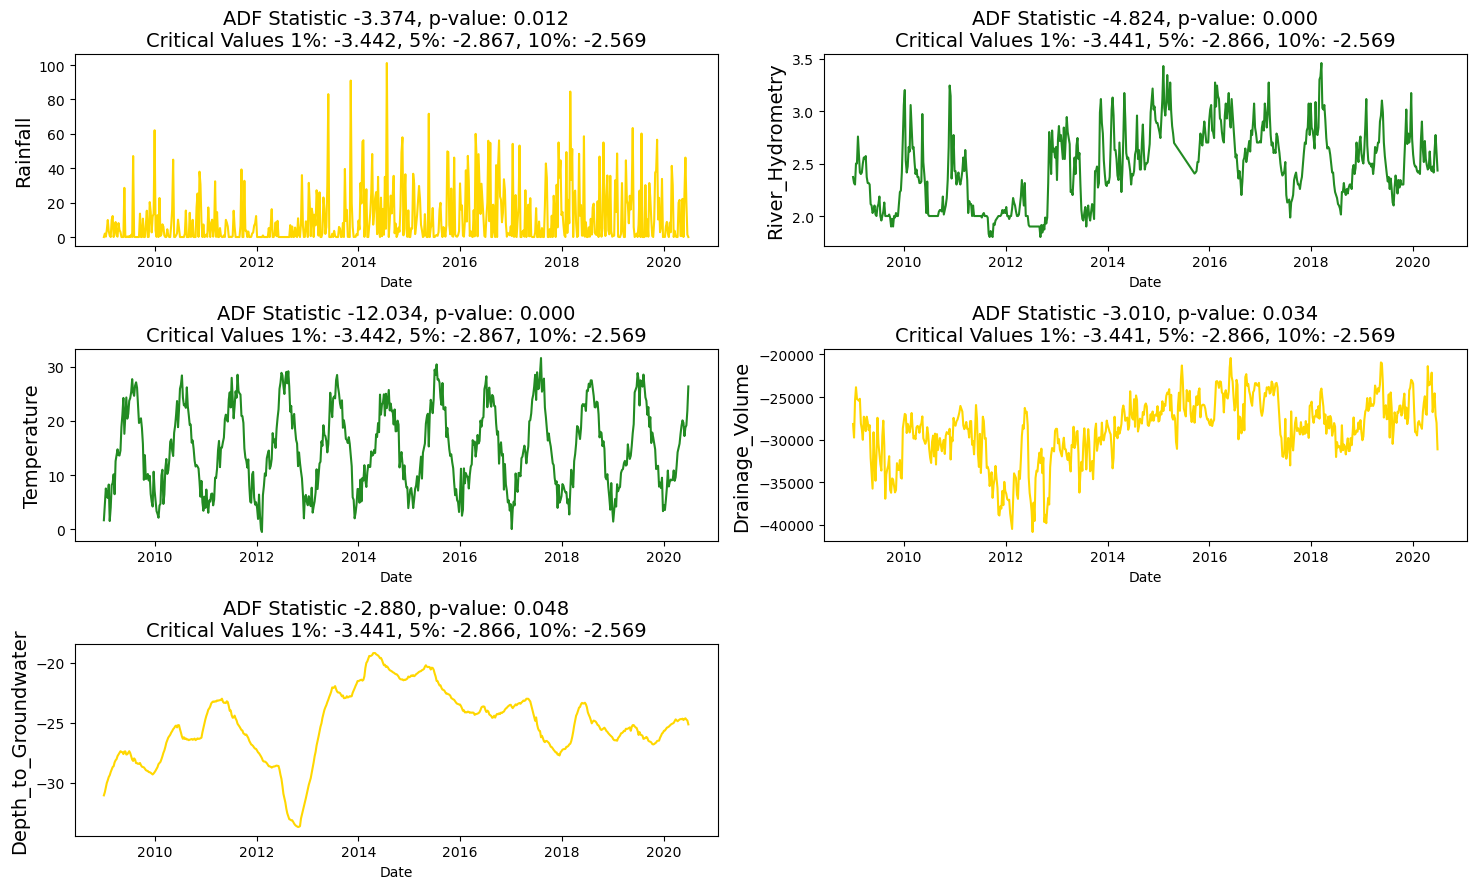

In [39]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=df.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df.Rainfall.values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df.Temperature.values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df.River_Hydrometry.values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df.Drainage_Volume.values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df.Depth_to_Groundwater.values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Если данные не стационарны, их можно преобразовать. Однако, если данные изначально не стационарны, можно выбрать другую модель))

**Два наиболее распространенных метода достижения стационарности:**

**Преобразование**: например. логарифм или квадратный корень для стабилизации непостоянной дисперсии

**Дифференцирование**: вычитаем текущее значение из предыдущего.

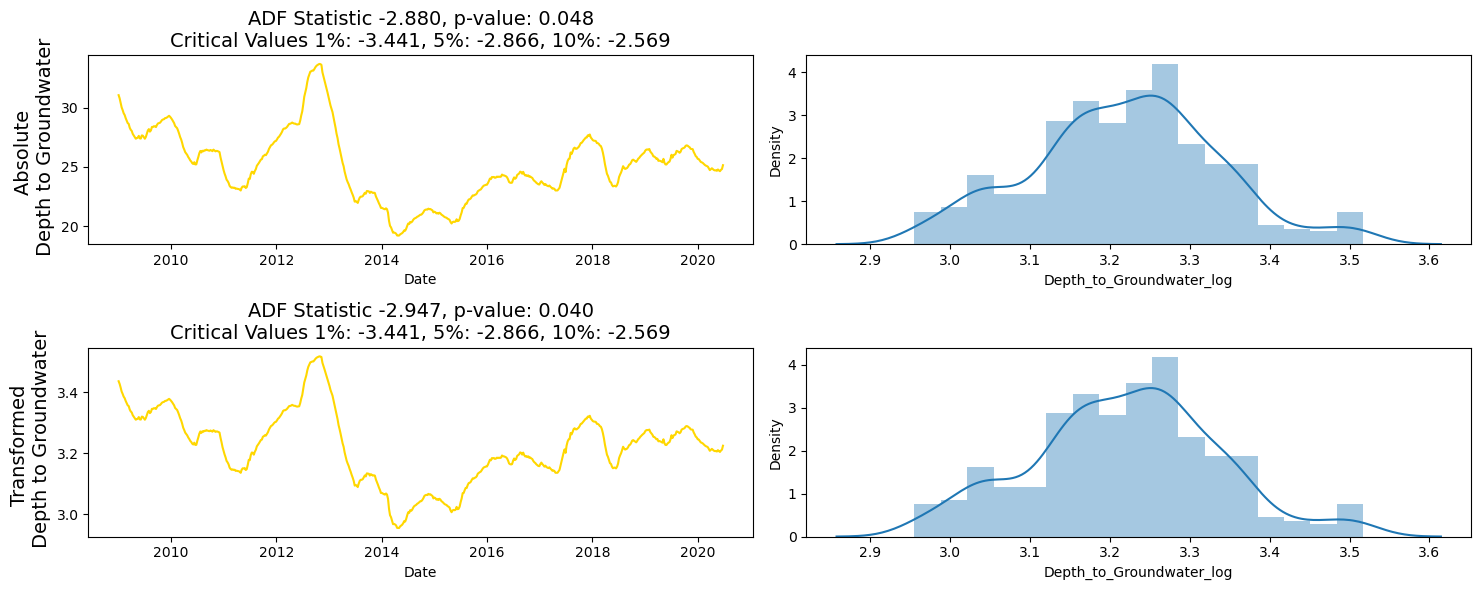

In [40]:
df['Depth_to_Groundwater_log'] = np.log(abs(df.Depth_to_Groundwater))
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
visualize_adfuller_results(abs(df.Depth_to_Groundwater), 'Absolute \n Depth to Groundwater', ax[0, 0])

sns.distplot(df.Depth_to_Groundwater_log, ax=ax[0, 1])
visualize_adfuller_results(df.Depth_to_Groundwater_log, 'Transformed \n Depth to Groundwater', ax[1, 0])

sns.distplot(df.Depth_to_Groundwater_log, ax=ax[1, 1])

plt.tight_layout()
plt.show()

In [41]:
# Первая разность
ts_diff = np.diff(df.Depth_to_Groundwater)
df['Depth_to_Groundwater_diff_1'] = np.append([0], ts_diff)

# Вторая разность
ts_diff = np.diff(df.Depth_to_Groundwater_diff_1)
df['Depth_to_Groundwater_diff_2'] = np.append([0], ts_diff)

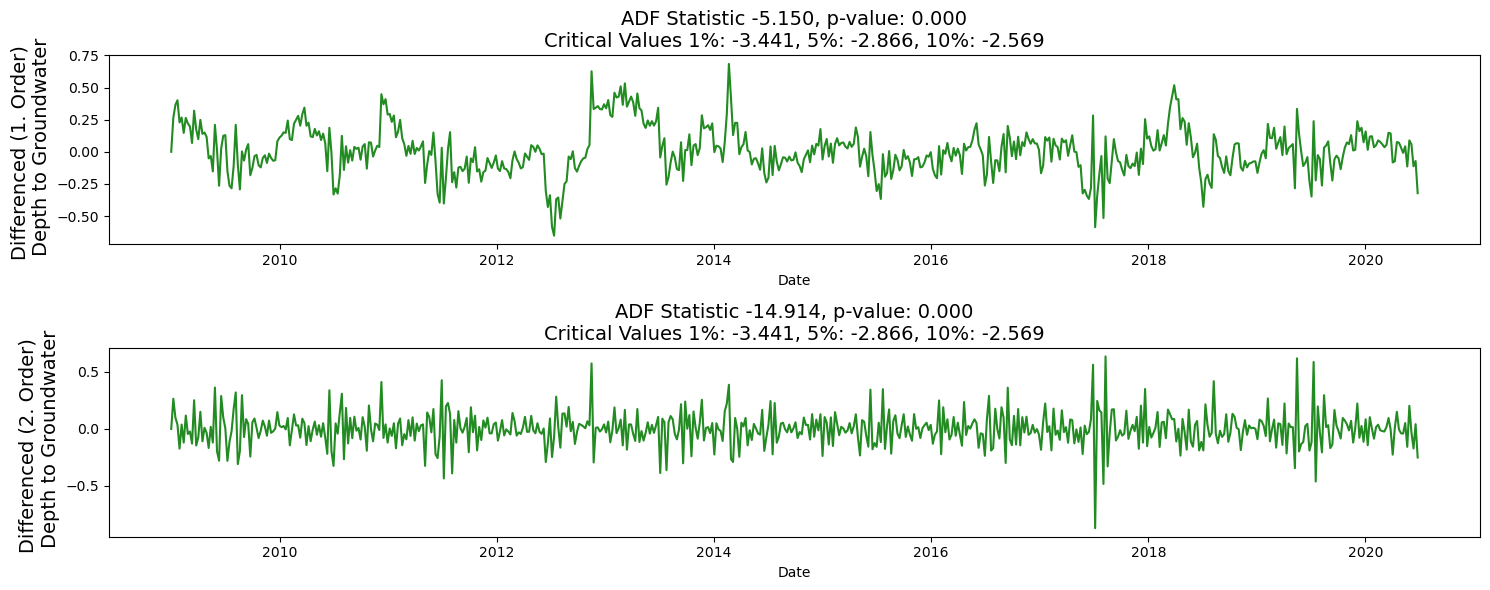

In [42]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

visualize_adfuller_results(df.Depth_to_Groundwater_diff_1, 'Differenced (1. Order) \n Depth to Groundwater', ax[0])
visualize_adfuller_results(df.Depth_to_Groundwater_diff_2, 'Differenced (2. Order) \n Depth to Groundwater', ax[1])
plt.tight_layout()
plt.show()

## Feature Engineering


In [43]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['season'] = df.month%12 // 3 + 1

df[['Date', 'year', 'month', 'day', 'day_of_year', 'quarter', 'season']].head()

,Date,year,month,day,day_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1
1,2009-01-08,2009,1,8,8,1,1
2,2009-01-15,2009,1,15,15,1,1
3,2009-01-22,2009,1,22,22,1,1
4,2009-01-29,2009,1,29,29,1,1


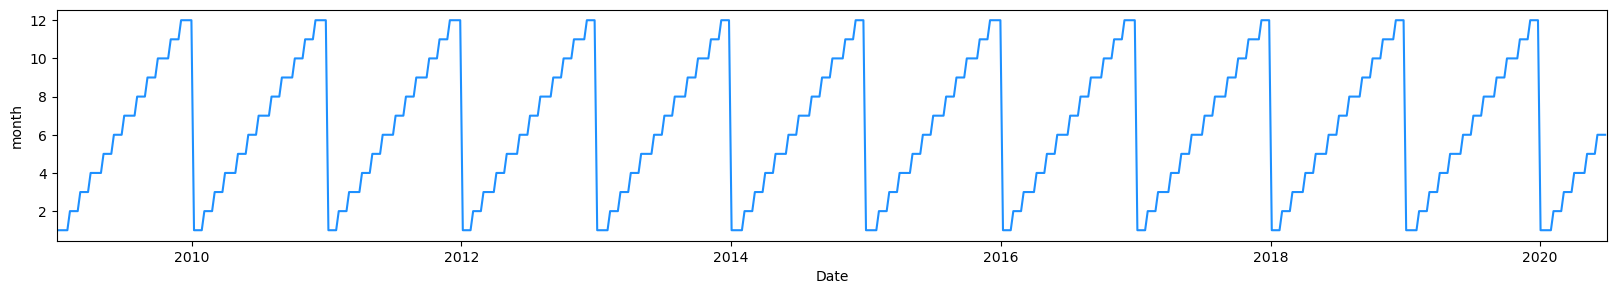

In [44]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df.Date, y=df.month, color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

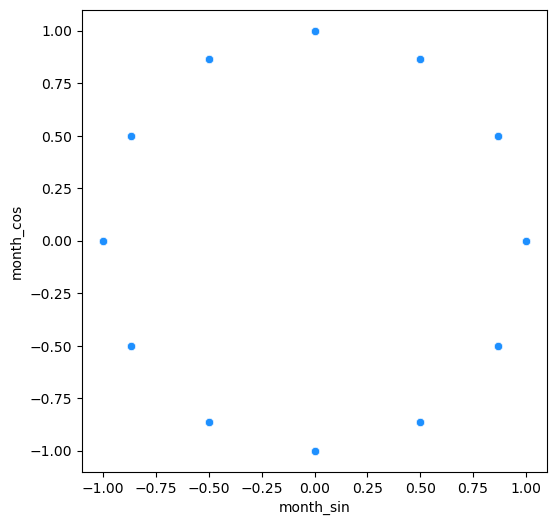

In [45]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df.month/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df.month/month_in_year)

days_in_month = 30
df['day_sin'] = np.sin(2*np.pi*df.day/days_in_month)
df['day_cos'] = np.cos(2*np.pi*df.day/days_in_month)

days_in_year = 365
df['day_of_year_sin'] = np.sin(2*np.pi*df.day_of_year/days_in_year)
df['day_of_year_cos'] = np.cos(2*np.pi*df.day_of_year/days_in_year)

quarters_in_year = 4
df['quarter_sin'] = np.sin(2*np.pi*df.quarter/quarters_in_year)
df['quarter_cos'] = np.cos(2*np.pi*df.quarter/quarters_in_year)

seasons_in_year = 4
df['season_sin'] = np.sin(2*np.pi*df.season/seasons_in_year)
df['season_cos'] = np.cos(2*np.pi*df.season/seasons_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

## Разложение на тренд/сезонность/шум

сложение: 𝑦(𝑡)=𝐿𝑒𝑣𝑒𝑙+𝑇𝑟𝑒𝑛𝑑+𝑆𝑒𝑎𝑠𝑜𝑛𝑎𝑙𝑖𝑡𝑦+𝑁𝑜𝑖𝑠𝑒

умножение: 𝑦(𝑡)=𝐿𝑒𝑣𝑒𝑙∗𝑇𝑟𝑒𝑛𝑑∗𝑆𝑒𝑎𝑠𝑜𝑛𝑎𝑙𝑖𝑡𝑦∗𝑁𝑜𝑖𝑠𝑒

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_cols =  ['Rainfall', 'Temperature', 
                   'Drainage_Volume', 
                   'River_Hydrometry', 'Depth_to_Groundwater']

for col in decompose_cols:
    decomp = seasonal_decompose(df[col], period=52, model='additive', extrapolate_trend='freq')
    df[f"{col}_trend"] = decomp.trend
    df[f"{col}_seasonal"] = decomp.seasonal

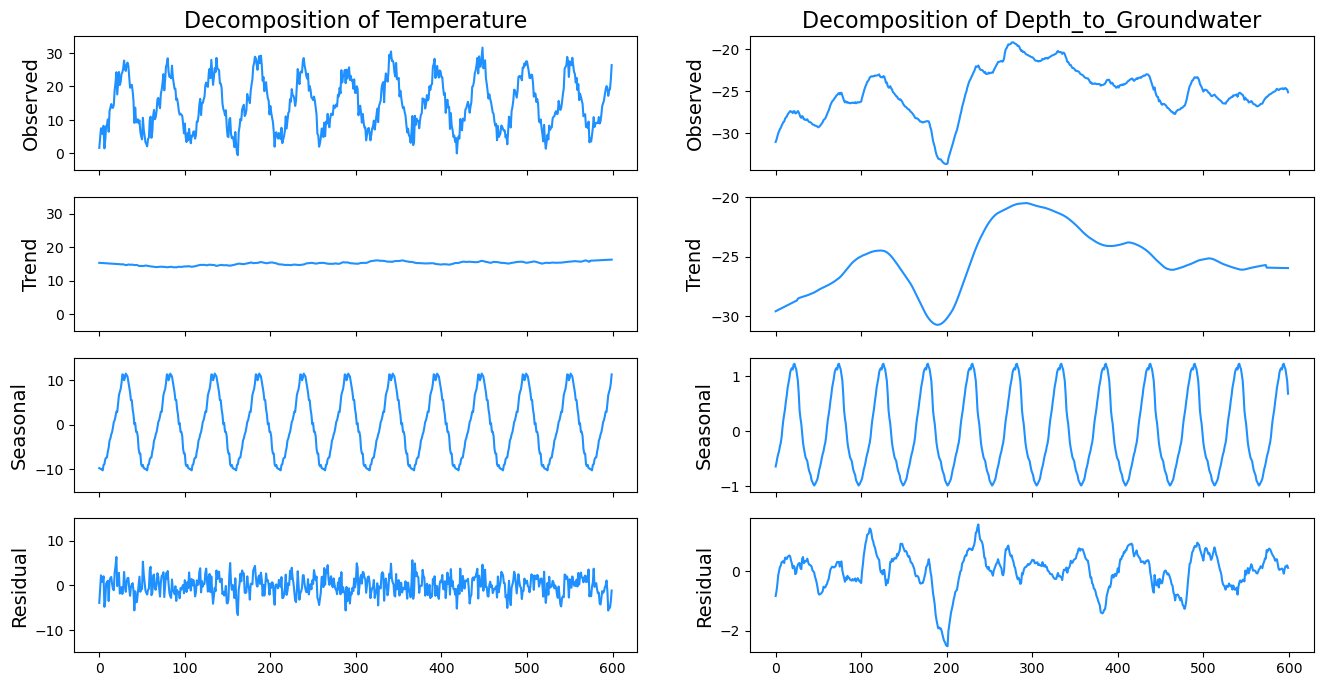

In [48]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(df.Temperature, period=52, model='additive', extrapolate_trend='freq')

ax[0,0].set_title('Decomposition of Temperature', fontsize=16)
res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
ax[0,0].set_ylabel('Observed', fontsize=14)
ax[0,0].set_ylim([-5, 35])

res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
ax[1,0].set_ylabel('Trend', fontsize=14)
ax[1,0].set_ylim([-5, 35])

res.seasonal.plot(ax=ax[2,0], legend=False, color='dodgerblue')
ax[2,0].set_ylabel('Seasonal', fontsize=14)
ax[2,0].set_ylim([-15, 15])

res.resid.plot(ax=ax[3,0], legend=False, color='dodgerblue')
ax[3,0].set_ylabel('Residual', fontsize=14)
ax[3,0].set_ylim([-15, 15])

ax[0,1].set_title('Decomposition of Depth_to_Groundwater', fontsize=16)
res = seasonal_decompose(df.Depth_to_Groundwater, period=52, model='additive', extrapolate_trend='freq')

res.observed.plot(ax=ax[0, 1], legend=False, color='dodgerblue')
ax[0, 1].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1, 1], legend=False, color='dodgerblue')
ax[1, 1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2, 1], legend=False, color='dodgerblue')
ax[2, 1].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3, 1], legend=False, color='dodgerblue')
ax[3, 1].set_ylabel('Residual', fontsize=14)

plt.show()

In [56]:
df[['Rainfall', 'Rainfall_trend', 'Rainfall_seasonal', 
          'Temperature', 'Temperature_trend', 'Temperature_seasonal', 
          'Drainage_Volume', 'Drainage_Volume_trend', 'Drainage_Volume_seasonal',
          'River_Hydrometry', 'River_Hydrometry_trend', 'River_Hydrometry_seasonal', 
          'Depth_to_Groundwater', 'Depth_to_Groundwater_trend', 'Depth_to_Groundwater_seasonal']].head()\
.style.set_properties(subset=['Rainfall_trend', 'Rainfall_seasonal', 
                              'Temperature_trend', 'Temperature_seasonal', 
                              'Drainage_Volume_trend', 'Drainage_Volume_seasonal', 
                              'River_Hydrometry_trend', 'River_Hydrometry_seasonal',
                              'Depth_to_Groundwater_trend', 'Depth_to_Groundwater_seasonal'
                             ], **{'background-color': 'dodgerblue'})

,Rainfall,Rainfall_trend,Rainfall_seasonal,Temperature,Temperature_trend,Temperature_seasonal,Drainage_Volume,Drainage_Volume_trend,Drainage_Volume_seasonal,River_Hydrometry,River_Hydrometry_trend,River_Hydrometry_seasonal,Depth_to_Groundwater,Depth_to_Groundwater_trend,Depth_to_Groundwater_seasonal
0,0.000000,5.644061,4.822633,1.657143,15.329959,-9.739920,-28164.918857,-32404.467037,1551.335303,2.371429,2.164913,0.207547,-31.048571,-29.571657,-0.643767
1,2.000000,5.663654,-5.096388,4.571429,15.312814,-9.838787,-29755.789714,-32374.371773,938.070633,2.314286,2.167252,0.186527,-30.784286,-29.535110,-0.572078
2,0.200000,5.683247,-5.019971,7.528571,15.295668,-10.002955,-25463.190857,-32344.276508,832.934327,2.300000,2.169592,0.105423,-30.420000,-29.498564,-0.484281
3,4.100000,5.702840,3.454367,6.214286,15.278522,-9.973161,-23854.422857,-32314.181244,518.836188,2.500000,2.171931,0.131993,-30.018571,-29.462017,-0.417712
4,9.900000,5.722433,-3.895493,5.771429,15.261377,-10.246938,-25210.532571,-32284.085980,238.454010,2.500000,2.174270,0.152668,-29.790000,-29.425470,-0.362900


In [49]:
weeks_in_month = 4

df['Temperature_seasonal_shift_r_2M'] = df.Temperature_seasonal.shift(-2*weeks_in_month)
df['Temperature_seasonal_shift_r_1M'] = df.Temperature_seasonal.shift(-1*weeks_in_month)
df['Temperature_seasonal_shift_1M'] = df.Temperature_seasonal.shift(1*weeks_in_month)
df['Temperature_seasonal_shift_2M'] = df.Temperature_seasonal.shift(2*weeks_in_month)
df['Temperature_seasonal_shift_3M'] = df.Temperature_seasonal.shift(3*weeks_in_month)

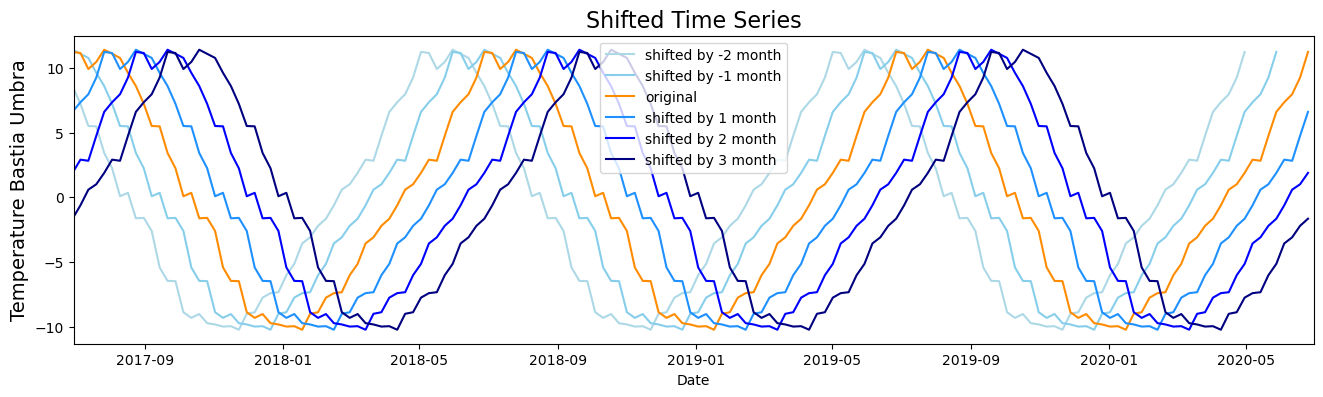

In [50]:
df['Drainage_Volume_seasonal_shift_r_2M'] = df.Drainage_Volume_seasonal.shift(-2*weeks_in_month)
df['Drainage_Volume_seasonal_shift_r_1M'] = df.Drainage_Volume_seasonal.shift(-1*weeks_in_month)
df['Drainage_Volume_seasonal_shift_1M'] = df.Drainage_Volume_seasonal.shift(1*weeks_in_month)
df['Drainage_Volume_seasonal_shift_2M'] = df.Drainage_Volume_seasonal.shift(2*weeks_in_month)
df['Drainage_Volume_seasonal_shift_3M'] = df.Drainage_Volume_seasonal.shift(3*weeks_in_month)

df['River_Hydrometry_seasonal_shift_r_2M'] = df.River_Hydrometry_seasonal.shift(-2*weeks_in_month)
df['River_Hydrometry_seasonal_shift_r_1M'] = df.River_Hydrometry_seasonal.shift(-1*weeks_in_month)
df['River_Hydrometry_seasonal_shift_1M'] = df.River_Hydrometry_seasonal.shift(1*weeks_in_month)
df['River_Hydrometry_seasonal_shift_2M'] = df.River_Hydrometry_seasonal.shift(2*weeks_in_month)
df['River_Hydrometry_seasonal_shift_3M'] = df.River_Hydrometry_seasonal.shift(3*weeks_in_month)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_r_2M, label='shifted by -2 month', ax=ax, color='lightblue')
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_r_1M, label='shifted by -1 month', ax=ax, color='skyblue')

sns.lineplot(x=df.Date, y=df.Temperature_seasonal, label='original', ax=ax, color='darkorange')

sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_1M, label='shifted by 1 month', ax=ax, color='dodgerblue')
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_2M, label='shifted by 2 month', ax=ax, color='blue')
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_3M, label='shifted by 3 month', ax=ax, color='navy')

ax.set_title('Shifted Time Series', fontsize=16)

ax.set_xlim([date(2017, 6, 30), date(2020, 6, 30)])
ax.set_ylabel(ylabel='Temperature Bastia Umbra', fontsize=14)

plt.show()

# EDA

Cезонность компонентов + сравнения минимумов и максимумов:

* Глубина залегания грунтовых вод достигает максимума примерно в мае/июне и минимума примерно в ноябре/декабре.

* Температура достигает максимума примерно в августе и минимума примерно в январе.

* Объем достигает максимума примерно в июне и минимума примерно в августе/сентябре. Для достижения максимума требуется больше времени, чем для достижения минимума.

* Гидрометрия достигает максимума примерно в марте и минимума примерно в сентябре.

* Объем и гидрометрия достигают минимума примерно в одно и то же время.

* Объем и гидрометрия достигают минимума, когда температура достигает максимума.
    
* Отставание температуры начинается в глубине грунтовых вод примерно на 2–3 месяца.

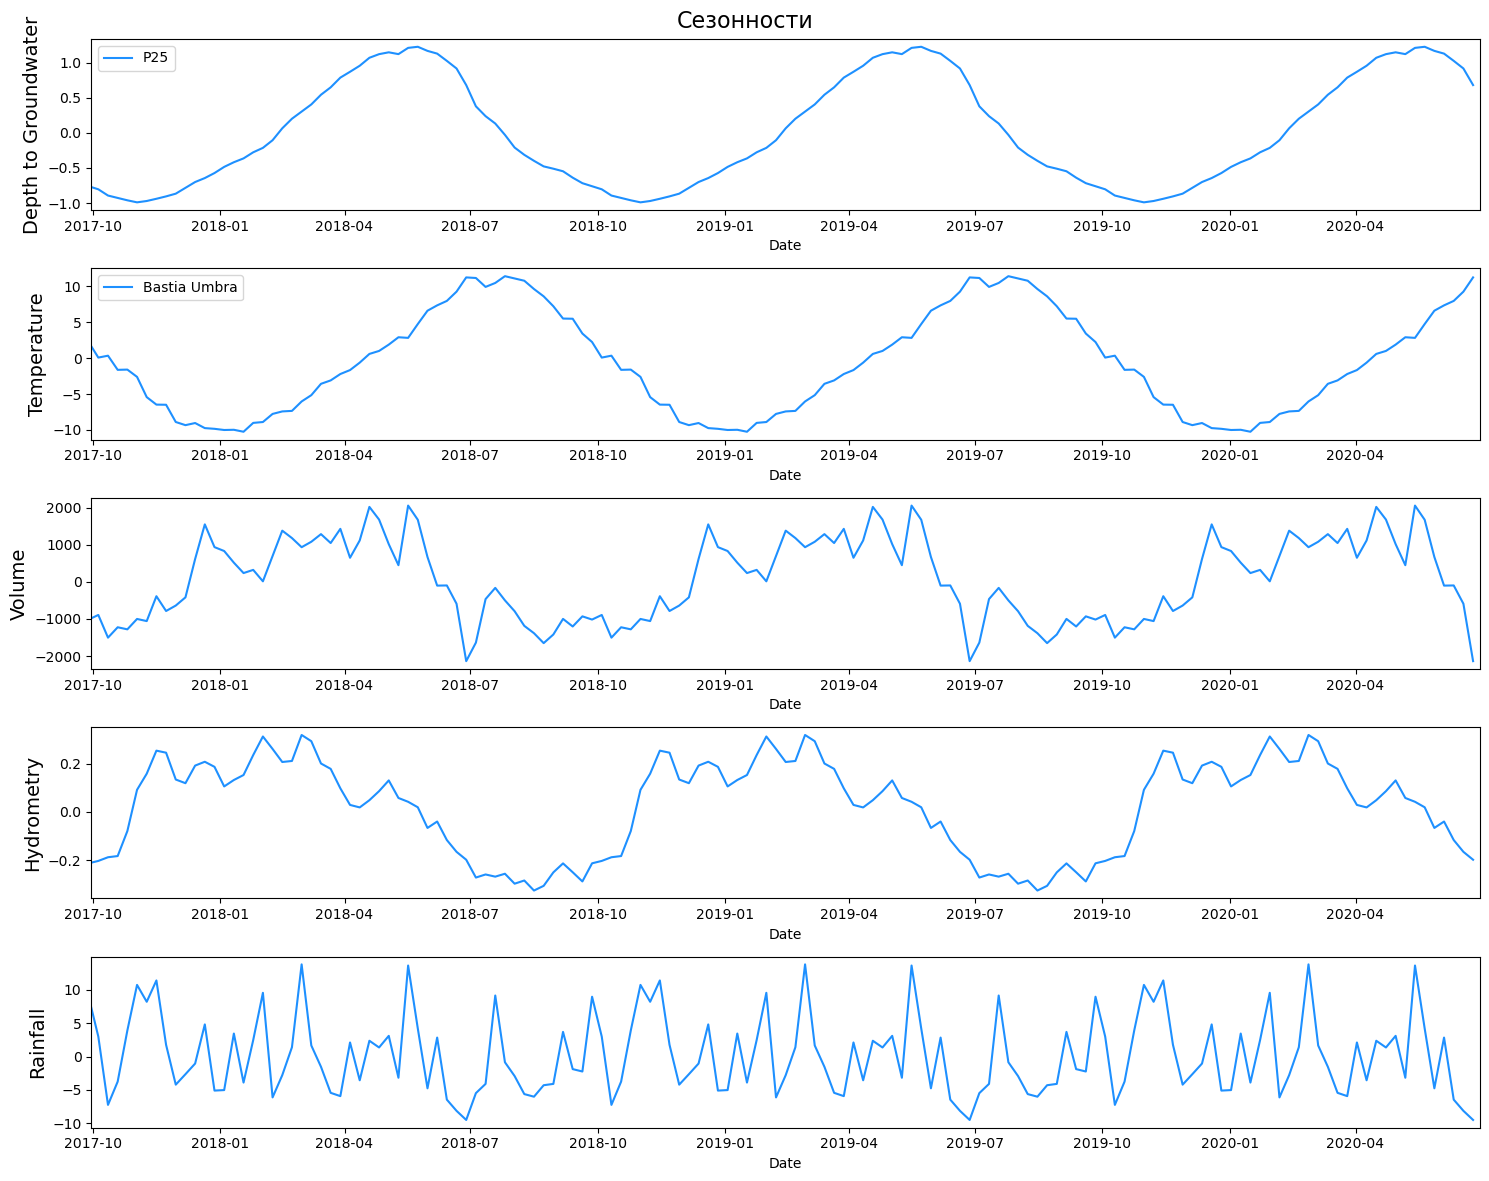

In [51]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Сезонности', fontsize=16)
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater_seasonal, ax=ax[0], color='dodgerblue', label='P25')
ax[0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature_seasonal, ax=ax[1], color='dodgerblue', label='Bastia Umbra')
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume_seasonal, ax=ax[2], color='dodgerblue')
ax[2].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry_seasonal, ax=ax[3], color='dodgerblue')
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Rainfall_seasonal, ax=ax[4], color='dodgerblue')
ax[4].set_ylabel(ylabel='Rainfall', fontsize=14)

for i in range(5):
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
plt.tight_layout()
plt.show()

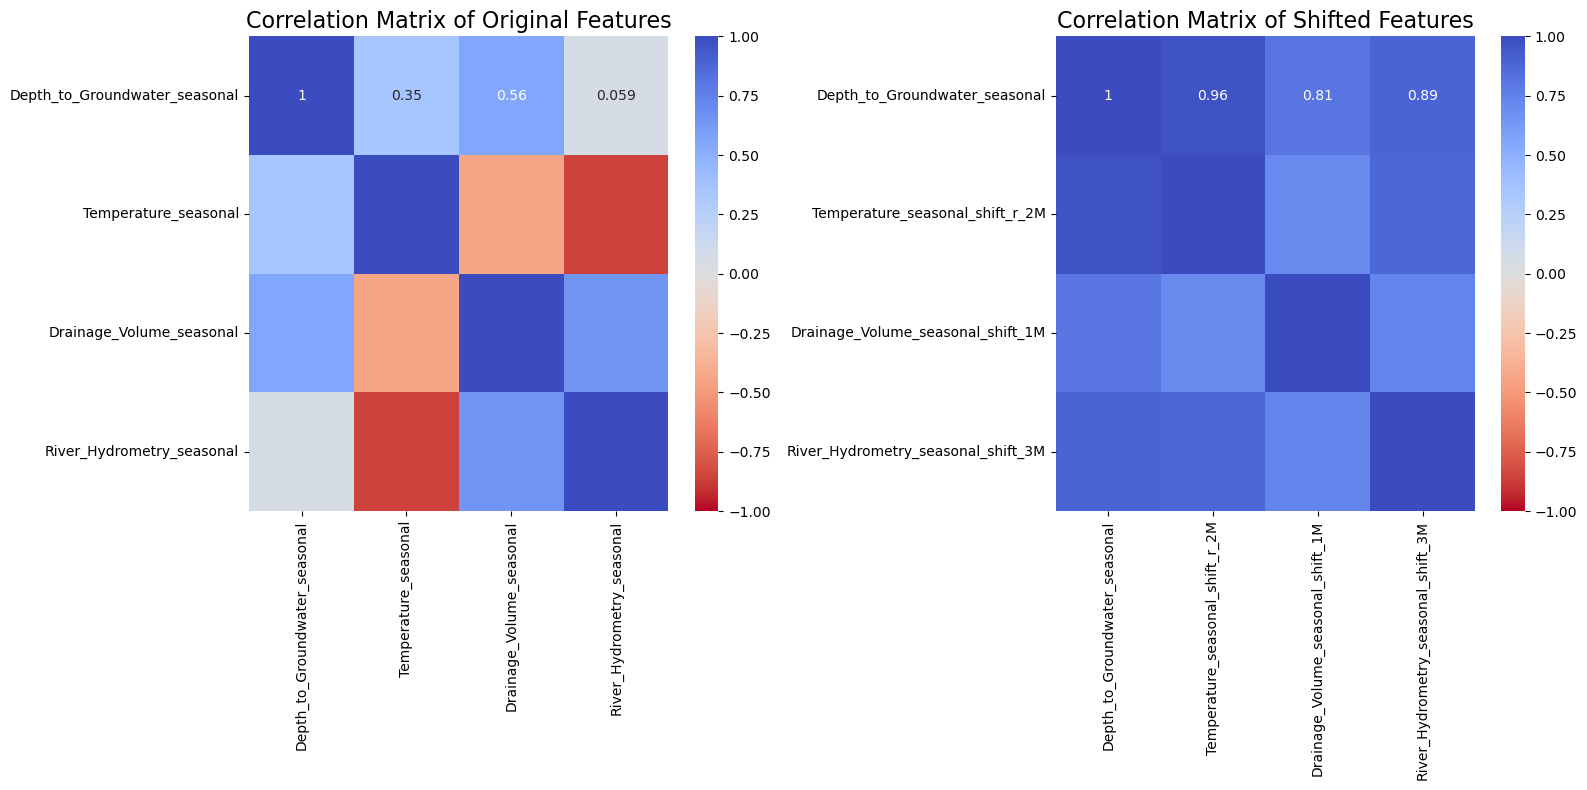

In [52]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

original_cols = ['Depth_to_Groundwater_seasonal', 
                 'Temperature_seasonal',
                 'Drainage_Volume_seasonal', 'River_Hydrometry_seasonal']

corrmat = df[original_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Original Features', fontsize=16)

shifted_cols = [ 'Depth_to_Groundwater_seasonal', 
                'Temperature_seasonal_shift_r_2M',
                'Drainage_Volume_seasonal_shift_1M', 'River_Hydrometry_seasonal_shift_3M']
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Shifted Features', fontsize=16)


plt.tight_layout()
plt.show()

# Прогноз

In [53]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df.Date
y = df.Depth_to_Groundwater

folds = TimeSeriesSplit(n_splits=N_SPLITS)

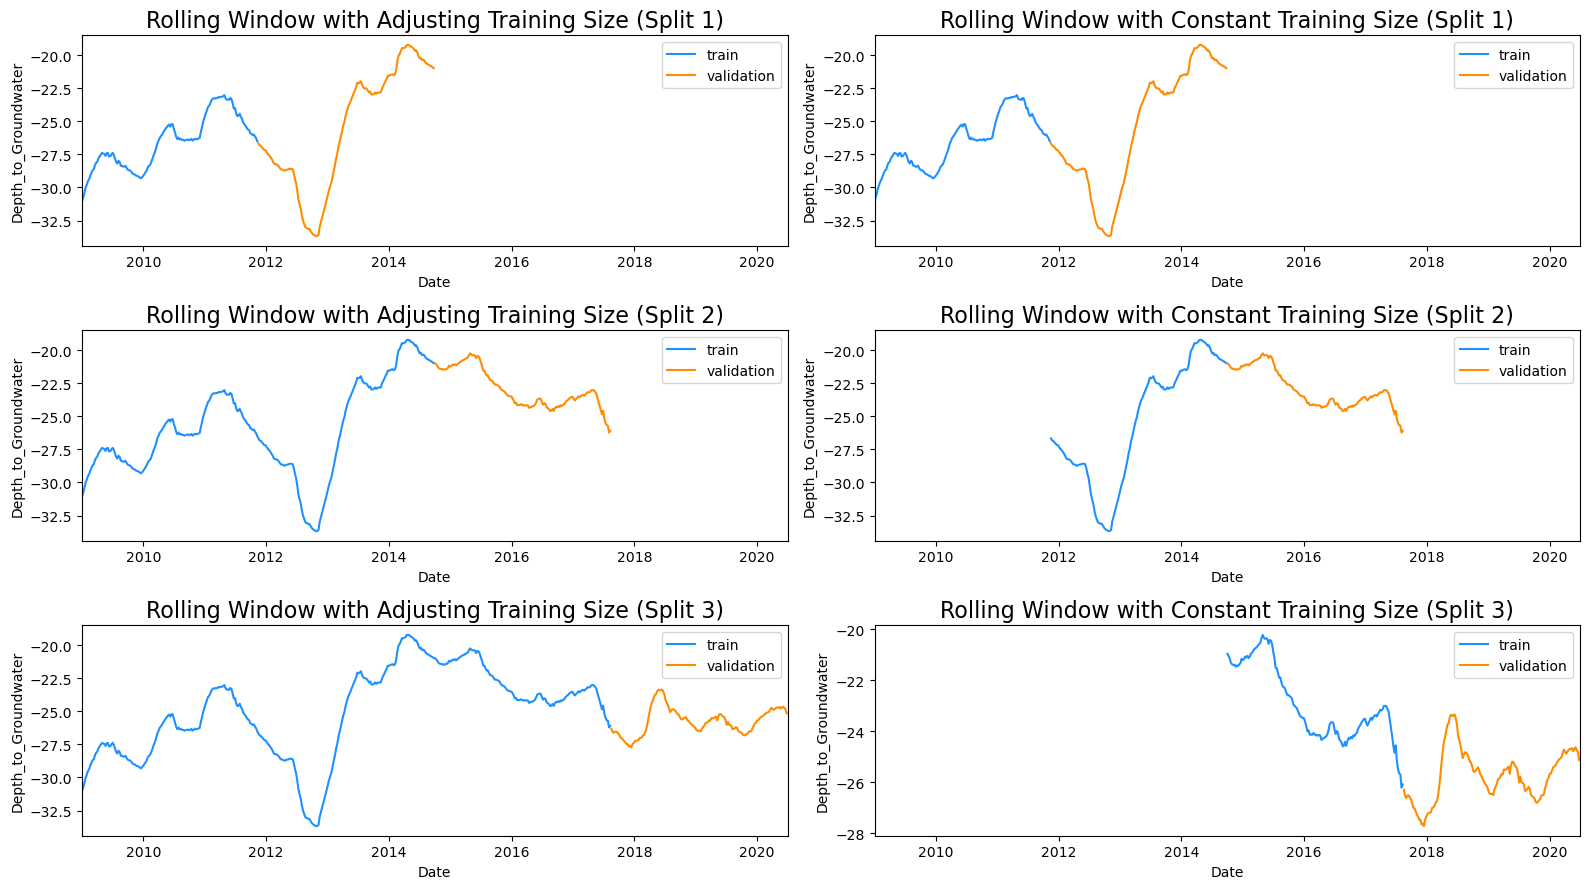

In [54]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.tight_layout()
plt.show()

In [55]:
df['quarter_idx'] = (df.quarter != df.quarter.shift(1)).cumsum()

target = 'Depth_to_Groundwater'
features = [feature for feature in df.columns if feature != target]

N_SPLITS = 46

X = df[df.quarter_idx < N_SPLITS][features]
y = df[df.quarter_idx < N_SPLITS][target]

X_test = df[df.quarter_idx == N_SPLITS][features].reset_index(drop=True)
y_test = df[df.quarter_idx == N_SPLITS][target].reset_index(drop=True)

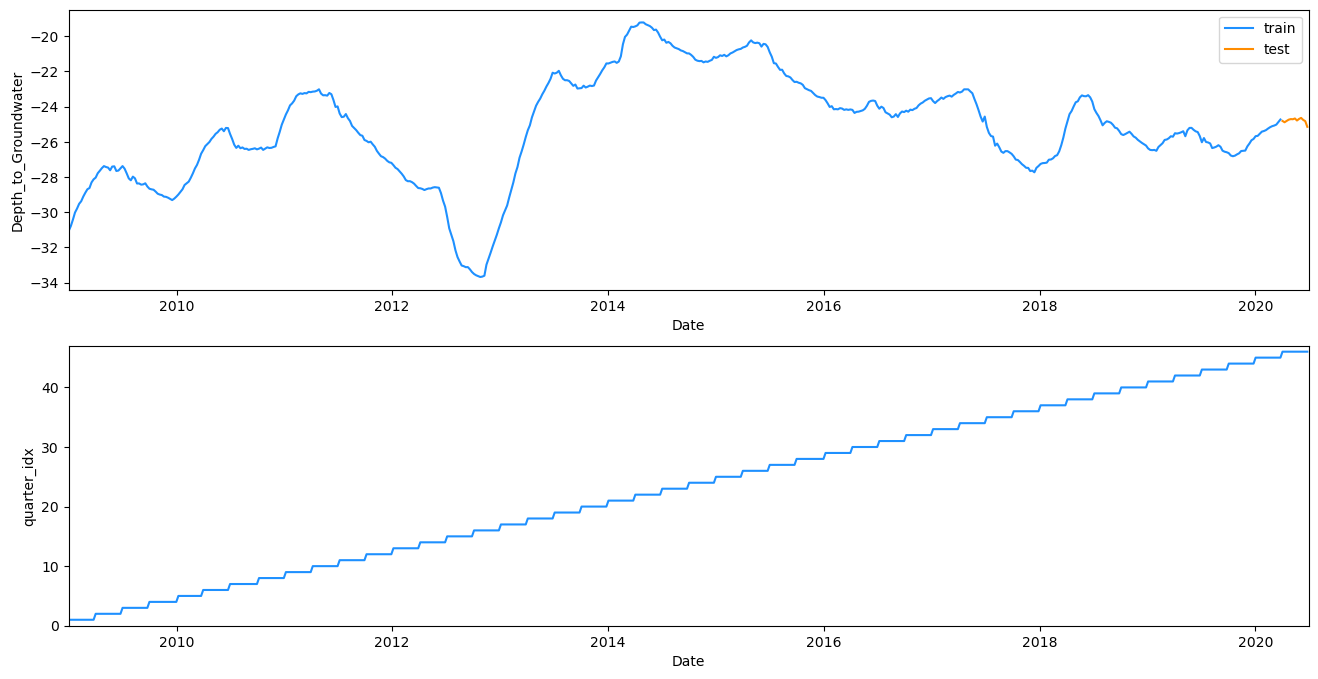

In [56]:
folds = np.linspace(0, N_SPLITS-3, num=N_SPLITS-2)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='train')
sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='darkorange', label='test')

sns.lineplot(x=df.Date, y=df.quarter_idx, ax=ax[1], color='dodgerblue')
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_ylim([0, N_SPLITS+1])
#ax[0].set_ylim([-28, -23])

plt.show()

# Заткнем предыдущим значением

In [57]:
# Рисовалка
def plot_approach_evaluation(y_pred, score_mae, score_rsme, approach_name):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2) #navajowhite
    sns.lineplot(x=X_test.Date, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    ax[0].set_xlim([date(2018, 6, 30), date(2020, 6, 30)])
    ax[0].set_ylim([-27, -23])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_valid, y_valid_pred)):.2f}', fontsize=14)
    ax[0].set_xlabel(xlabel='Date', fontsize=14)
    ax[0].set_ylabel(ylabel='Depth to Groundwater P25', fontsize=14)

    sns.lineplot(x=folds, y=score_mae,  color='gold', label='MAE', ax=ax[1])#marker='o',
    sns.lineplot(x=folds, y=score_rsme, color='indianred', label='RSME', ax=ax[1])
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel(xlabel='Fold', fontsize=14)
    ax[1].set_ylabel(ylabel='Loss', fontsize=14)
    ax[1].set_ylim([0, 4])   
    plt.show()

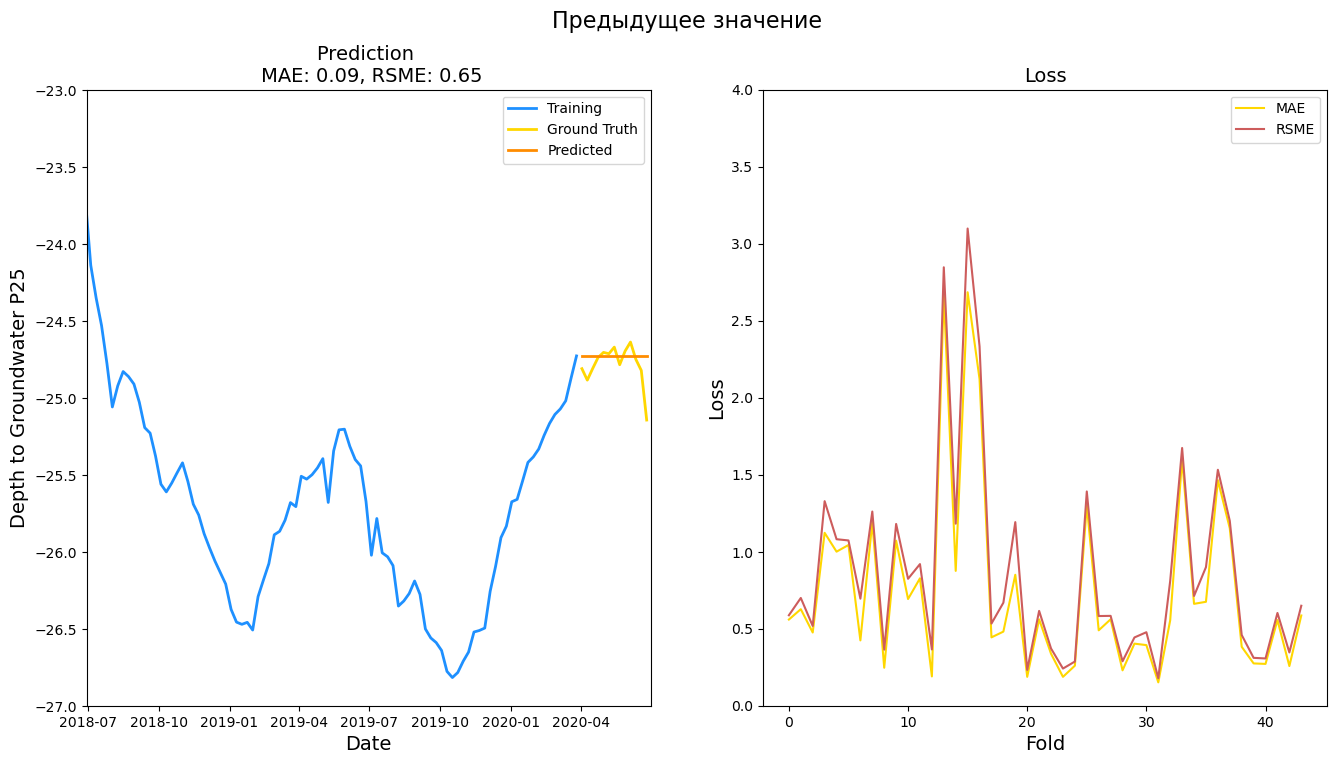

In [58]:
score_mae = []
score_rsme = []
for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    #X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Initialize y_valid_pred
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # Prediction: Naive approach
    y_valid_pred = y_valid_pred * y_train.iloc[-1]
    
    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.ones(len(X_test))) * y.iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Предыдущее значение')

# Скользящее среднее за 4 недели

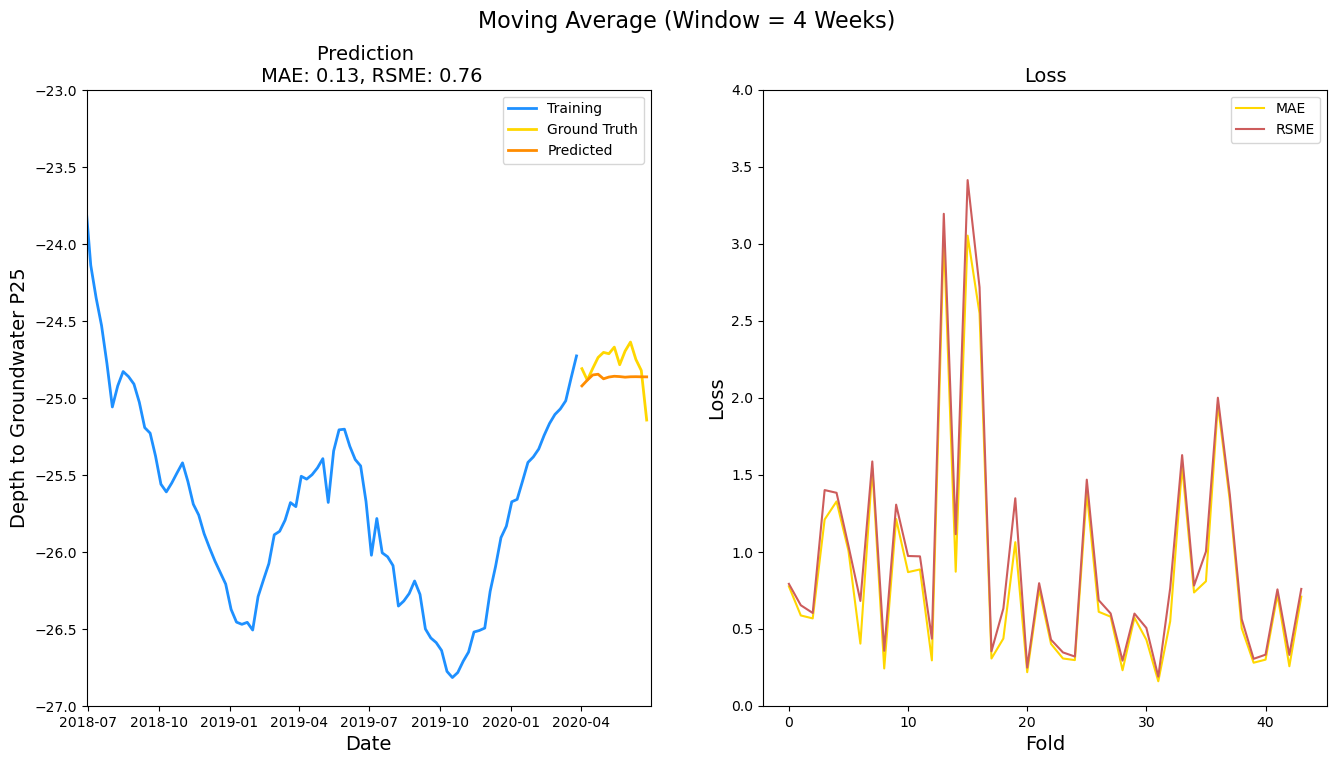

In [59]:
score_mae = []
score_rsme = []
for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    #X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Initialize y_valid_pred
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # Prediction: Naive approach    
    for i in range(len(y_valid_pred)):
        y_valid_pred.iloc[i] = y_train._append(y_valid_pred.iloc[:(i)]).reset_index(drop=True).rolling(4).mean().iloc[-1]
        
    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.zeros(len(X_test)))

for i in range(len(y_pred)):
    y_pred.iloc[i] = y._append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(4).mean().iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Moving Average (Window = 4 Weeks)')

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

score_mae = []
score_rsme = []

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Fit model with Vector Auto Regression (VAR)
    model = ARIMA(y_train, order=(1,1,1))
    model_fit = model.fit()
    
    # Prediction with Vector Auto Regression (VAR)
    y_valid_pred = model_fit.predict(valid_index[0], valid_index[-1])

    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))


# Fit model with Vector Auto Regression (VAR)
model = ARIMA(y, order=(1,1,1))
model_fit = model.fit()

# Prediction with Vector Auto Regression (VAR)
y_pred = model_fit.predict(y.index[-1]+1, y.index[-1] + len(y_test)).reset_index(drop=True)
plot_approach_evaluation(y_pred, score_mae, score_rsme, 'ARIMA')